<font color=Navy><b>SentimentAnalysis using Simple RNN <br>
This example illustrates the sentiment analysis on MovieReview Comments.


<font color=Navy><b>Data Set:
The data set contains Moviereview comments. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. 
Each Sentence has been parsed into many phrases. 
train.tsv contains the phrases and their associated sentiment labels.<br>
test.tsv contains just phrases. 
It is required to assign a sentiment label to each phrase.
The sentiment labels are:<br>

0 - negative <br>
1 - somewhat negative<br>
2 - neutral<br>
3 - somewhat positive<br>
4 - positive <br>   

Import numpy and Pandas

In [79]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import classification_report

Read train and test data from csv file

In [44]:
df = pd.read_csv('input/sentences_and_phrases_150k/train.csv')

In [45]:
test_df = pd.read_csv('input/sentences_and_phrases_150k/test.csv')

In [46]:
test_df

,Phrase
0,An intermittently pleasing but mostly routine ...
1,An intermittently pleasing but mostly routine ...
2,An
3,intermittently pleasing but mostly routine effort
4,intermittently pleasing but mostly routine
...,...
64,-RRB-
65,that serves
66,serves
67,as yet another example of the sad decline of B...


In [47]:
from numpy import random
ix = list(range(df.shape[0]))
ix = random.permutation(ix)
div = int(df.shape[0] * 0.7)
train_df = df.iloc[ix[0:div]]
validation_df = df.iloc[ix[div:]]

count plot on single categorical variable

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

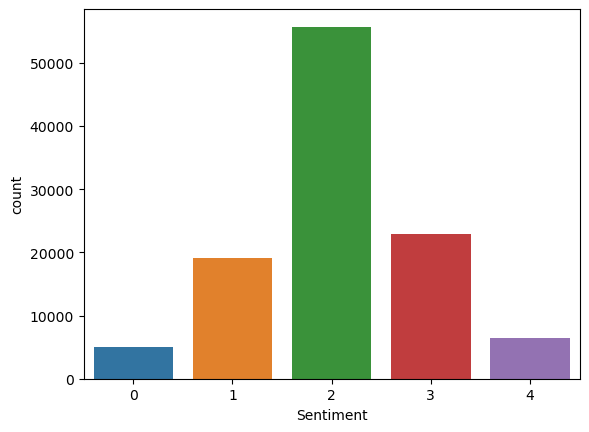

In [48]:
import seaborn as sns
sns.countplot(x ='Sentiment', data = train_df)


In [49]:
train_df['Sentiment'].value_counts()

2    55723
3    22917
1    19105
4     6492
0     5005
Name: Sentiment, dtype: int64

In [50]:
import nltk, re

<font color=Navy><b>The below function is used to preprocess the train and test data.<br>
1.fillna(0) -fills NaN values (if any )with zero<br>
2.Regular expression is used to match only the text data from the phrase<br>
3. The text is the split to get the sentence.<br>
4. every sentence is appended to Corpus for next use<br>

Note: Stemming or leematization or stop wordremoval is not applied here. Practioners can consider doing it for better result

In [51]:
def func(X):
    X=X.fillna(0)
    messages = X.copy()
    messages.reset_index(inplace=True)
    corpus=[]
    for i in range(len(messages)):
        review = re.sub('[^a-zA-Z]',' ',str(messages['Phrase'][i]))
        review = review.split()
        review = ' '.join(review)
        corpus.append(review)
        
    return corpus

In [53]:
corpus_train = func(train_df)
corpus_validation = func(validation_df)
corpus_test = func(test_df)

<font color=Navy><b>The below function get_wordlist() will split the training/ test data to extract the words. 

In [54]:
def get_wordlist(corpus1):
    words = []
    for phrase in corpus1:
        for word in phrase.split():
            words.append(word)       
             
    words.sort()
    return set(words)

In [55]:
word_set_train = get_wordlist(corpus_train)
word_set_validation = get_wordlist(corpus_validation)
word_set_test = get_wordlist(corpus_test)

<font color=Navy><b> the below function get_dicts() takes the set of words as input and generate index to each word

In [56]:
def get_dicts(word_set):
    word_to_index = {}
    for i, word in enumerate(word_set):
        word_to_index[word] = i  
        
    index_to_word = {index:word for (word, index) in word_to_index.items()}
    
    return word_to_index, index_to_word

In [57]:
word_to_index_train, index_to_word_train = get_dicts(word_set_train)
word_to_index_validation, index_to_word_validation = get_dicts(word_set_validation)
word_to_index_test, index_to_word_test = get_dicts(word_set_test)

<font color=Navy><b>the below function token () generates token with index

In [58]:
def token(corpus, word_to_index):
    tokenized_list = []
    
    for phrase in corpus:
        tokenized_format = []
        for word in phrase.split():
            index = word_to_index[word]
            tokenized_format.append(index)
            
        tokenized_list.append(tokenized_format)
        
    return np.array(tokenized_list, dtype='object')

In [14]:
from tensorflow import keras

In [59]:
X_train = token(corpus_train, word_to_index_train)
X_validation = token(corpus_validation, word_to_index_validation)
X_test = token(corpus_test, word_to_index_test)

<font color=Navy><b>In order to train the RNN on the tokenized data, all text input  must have the same length.<br>
We will limit the maximum review length to maxlen=30 by truncating longer reviews and padding shorter reviews with a null value (0).<br>
Keras pad_sequences() function is used to accomplish this .<br>


In [60]:
maxlen = 30
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_validation_padded = keras.preprocessing.sequence.pad_sequences(X_validation, maxlen=maxlen, padding='post')
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

<font color=Navy><b>extract the label from the train data

In [61]:
y_train = train_df.iloc[:,-1].values
y_validation = validation_df.iloc[:,-1].values

<font color=Navy><b>Encode the label using one hot encoder

In [62]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))

# <font color=Navy>Design an RNN model for sentiment analysis

<font color=Navy>the below code demonstrates the architecture of RNN built.<br>
input is a sequence of words i.e,, integer word IDs of maximum length = 30<br>
output is a  sentiment label (0, 1,2,3,4).


In [63]:
#import the Keras layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense, Dropout, LSTM, Dropout

In [64]:
vocabulary_size = len(word_to_index_train) + 1
embedding_size=30

<font color=Navy><b>A simple RNN model is built with 1 embedding layer, 1 simple RNN layer , 1 dense layer as hidden layer and one dense layer as output layer.<br>
1.A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.<br>
2.Keras Embedding Layer takes encoded text data as input. Embedding layer is used as the first hidden layer of a network.
It takes 3 arguments.Embedding(input dimension, out_dimension=embedding_size, trainable=True).Embedding layer has weights that are learned. <br>
3.Simple RNN () class is a complete RNN layer in Keras with input unit = 32 neurons. It is a Fully-connected RNN where the output is to be fed back to input. for more detials visit the website: https://keras.io/api/layers/recurrent_layers/simple_rnn/<br>
3.A dense layer which is deeply connected with its preceding layer. The dense layer’s neuron in a model receives output from every neuron of its preceding layer, where neurons of the dense layer perform matrix-vector multiplication. Row vector of the output from the preceding layers (RNN layer) is equal to the column vector of the dense layer. 
4. Last dense layer is the Output layer with 5 nodes indicating the probabilities of sentiment calculated.

In [65]:
import tensorflow as tf
model = tf.keras.Sequential([   
    tf.keras.layers.Embedding(vocabulary_size, embedding_size, trainable=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='sigmoid')
])

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 30)          503430    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2016      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 505,831
Trainable params: 505,831
Non-trainable params: 0
_________________________________________________________________


total 507,947 parameters  need to be trained.

<font color=Navy>Hyper Parameter<br>
We first need to compile our model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics we’d like to measure.<br>
Specify the appropriate parameters, including at least one metric ‘accuracy’.
Optimizer used:Adam optimizer is used as it has the most beneficial nature of  its adaptive learning rate. It can compute adaptive learning rates for different parameters.
Loss Function: Since, the label is one-hot encoded, categorical_crossentropy is used as loss function. suppose, the label is not one hot enocded, one can use Sparse_categorical_crossentropy as loss function.

In [67]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [68]:
model.fit(X_train_padded, y_train_encoded, batch_size=256, epochs=5 )

Epoch 1/5
427/427 [==============================] - 9s 19ms/step - loss: 1.2401 - accuracy: 0.5143
Epoch 2/5
427/427 [==============================] - 8s 18ms/step - loss: 1.0842 - accuracy: 0.5567
Epoch 3/5
427/427 [==============================] - 8s 18ms/step - loss: 1.0129 - accuracy: 0.5849
Epoch 4/5
427/427 [==============================] - 8s 18ms/step - loss: 0.9300 - accuracy: 0.6288
Epoch 5/5
427/427 [==============================] - 8s 18ms/step - loss: 0.8159 - accuracy: 0.6783


In [87]:
pred_validation = model.predict(X_validation_padded)
pred1_validation = (pred_validation > 0.5).astype(int)
labels = [0, 1, 2, 3, 4]
LABELS_validation = [labels[i] for i in model.predict(X_validation_padded).argmax(axis=-1)]

1464/1464 [==============================] - 6s 4ms/step


In [88]:
validation_df

,Phrase,Sentiment
94982,another iteration of what 's become one of the...,1
132780,#NAME?,2
25924,remember the lessons of the trickster spider,2
115983,the transcendent performance,4
45321,the flaws inherent in how medical aid is made ...,2
...,...,...
120005,of American Pie hijinks,1
20999,viewing alternative,2
137663,Thriller directorial debut for Traffic scribe ...,3
14412,"It challenges , this nervy oddity , like moder...",3


In [89]:
pred_validation

array([[0.35124218, 0.49508047, 0.42328304, 0.40976202, 0.49353117],
       [0.01830212, 0.26754817, 0.89429593, 0.31163877, 0.01045383],
       [0.12968063, 0.2599892 , 0.33151105, 0.6286491 , 0.69934726],
       ...,
       [0.44079593, 0.72953033, 0.52047783, 0.4344295 , 0.26073414],
       [0.01559354, 0.29176456, 0.7811119 , 0.503976  , 0.02066441],
       [0.01887997, 0.26541346, 0.6408404 , 0.60548234, 0.06311299]],
      dtype=float32)

In [91]:
print(classification_report(validation_df['Sentiment'], y_pred = LABELS_validation, labels = labels))

              precision    recall  f1-score   support

           0       0.06      0.03      0.04      2067
           1       0.21      0.14      0.17      8168
           2       0.56      0.64      0.60     23859
           3       0.22      0.22      0.22     10010
           4       0.08      0.11      0.09      2714

    accuracy                           0.40     46818
   macro avg       0.23      0.23      0.22     46818
weighted avg       0.38      0.40      0.39     46818



In [75]:
pred = model.predict(X_test_padded)
pred1=(pred > 0.5).astype(int)

3/3 [==============================] - 0s 5ms/step


The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [86]:
labels = ['negative', 'somewhat negative', 'neutral','somewhat positive','positive']
LABELS=[labels[i] for i in model.predict(X_test_padded).argmax(axis=-1)]

3/3 [==============================] - 0s 6ms/step


Predicted labels

<font color=Navy>creating a dataframe with Phrase and Sentiment columns

In [72]:
predicted = pd.DataFrame({'Phrase': test_df.iloc[:,0].values, 'Sentiment': LABELS})

<font color=Navy> Printing the predicted sequence

In [36]:
predicted


,Phrase,Sentiment
0,An intermittently pleasing but mostly routine ...,negative
1,An intermittently pleasing but mostly routine ...,negative
2,An,neutral
3,intermittently pleasing but mostly routine effort,negative
4,intermittently pleasing but mostly routine,negative
...,...,...
64,-RRB-,neutral
65,that serves,somewhat positive
66,serves,neutral
67,as yet another example of the sad decline of B...,positive


<font color=Navy> writing the predicted sequence to .csv file